<font color='tomato'><font color="#CC3D3D"><p>
# Automated Hyperparameter Tuning with Keras Tuner 
https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko 

##### Import modules

In [1]:
#압축을 풀어 keras tuner 설치
!pip install -q -U keras-tuner

You should consider upgrading via the 'c:\users\jangseonghyun\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from IPython.display import Image, clear_output
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
print(tf.__version__)

2.3.1


##### Set random seeds to make your results reproducible
- seed 를 잘 다루면 성능이 엄청 다르게 나타날 수도 있다

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


### Step 1: Load and process the data

##### Read data

In [6]:
# 앞 단계(Feature Enginnering)에서 저장했던 훈련/평가/적용 데이터를 읽어온다.
X_train, X_test, y_train, y_test, X_dep, ID_dep = pd.read_pickle('2nd_data.pkl')

# 모델링에 사용되는 최종 학습 및 평가 데이터 확인
X_train.shape, X_test.shape, X_dep.shape

((15110, 545), (6477, 545), (14380, 545))

##### Feature scaling

In [5]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

##### Split data into train & validation set 

In [7]:
# Train/Validation
i = int(round(X_train.shape[0] * 0.8,0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

### Step 2: Define the hyper-model -- 이걸 좀 고치고 밑에 epochs를 키워봐라.

In [8]:
def model_fn(hp):
    inputs = keras.Input(shape=(X_train.shape[1],))
    x = inputs
    for i in range(hp.Int('num_layers', 2, 3)):
        x = keras.layers.Dense(hp.Int('unit_'+str(i), 16, 64, step=16), activation='relu')(x)
        x = keras.layers.Dropout(hp.Float('dropout_'+str(i), 0, 0.5, step=0.25, default=0.5))(x)
    outputs = keras.layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  metrics=[keras.metrics.RootMeanSquaredError()])
    return model

### Step 3: Perform the hyper-tuning

In [9]:
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_root_mean_squared_error', direction="min"), 
                     max_epochs=10,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='dnn_tuning')

tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 60 Complete [00h 00m 03s]
val_root_mean_squared_error: 8.260372161865234

Best val_root_mean_squared_error So Far: 8.260372161865234
Total elapsed time: 00h 02m 10s
INFO:tensorflow:Oracle triggered exit


### Step 4: Build the model

##### Get the bast model

In [10]:
model = tuner.get_best_models(1)[0]
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 545)]             0         
_________________________________________________________________
dense (Dense)                (None, 48)                26208     
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 28,609
Trainable params: 28,609
Non-trainable params: 0
__________________________________________________

In [11]:
tuner.results_summary(1)

Results summary
Results in dnn_tuning\untitled_project
Showing 1 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
unit_0: 48
dropout_0: 0.0
unit_1: 48
dropout_1: 0.0
learning_rate: 0.001
unit_2: 32
dropout_2: 0.25
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 8.260372161865234


##### Build the model with the optimal hyperparameters and train it on the data

In [11]:
#best_hps = tuner.get_best_hyperparameters(1)[0]
#model = tuner.hypermodel.build(best_hps)
#hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

# Visualize training history
#plt.plot(hist.history["loss"], label="train")
#plt.plot(hist.history["val_loss"], label="validation")
#plt.legend()
#plt.xlabel('epoch')
#plt.title("Loss")
#plt.show()

#plt.plot(hist.history["root_mean_squared_error"], label="train")
#plt.plot(hist.history["val_root_mean_squared_error"], label="validation")
#plt.legend()
#plt.xlabel('epoch')
#plt.title("RMSE")
#plt.show()

### Step 5: Evaluate the model performance

In [12]:
# Loss & RMSE
model.evaluate(X_test, y_test)

203/203 [==============================] - 0s 581us/step - loss: 75.0265 - root_mean_squared_error: 8.6618


[75.0264892578125, 8.661783218383789]

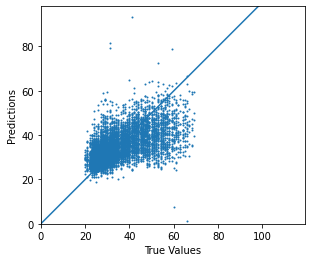

In [13]:
# Ground truth vs Prediction
test_predictions = model.predict(X_test).flatten()
plt.scatter(y_test, test_predictions, s=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 100], [0, 100])

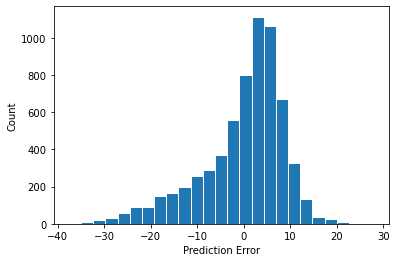

In [14]:
# Residual distribution
error = test_predictions - y_test
plt.hist(error, bins = 25, edgecolor='w')
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

### Step 6: Predict unseen data

In [14]:
# Generates output predictions for the input samples
model.predict(X_dep).flatten()

array([39.668148, 36.56108 , 26.491161, ..., 32.907784, 31.986599,
       26.186161], dtype=float32)

In [15]:
# Make submissions: (결과) 9.00191
t = pd.Timestamp.now()
fname = f"dnn_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'custid': ID_dep, 'age': model.predict(X_dep).flatten()}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dnn_submission_06091716.csv' is ready to submit.


###  Step 7: Save the model for future use

In [17]:
# pickle 형식으로 저장
# with open('nn_model.pkl', 'wb') as f:
#    pickle.dump(model, f)

# 추후 저장한 모형 불러올 때: 
# model = pd.read_pickle('nn_model.pkl')

In [18]:
# h5 형식으로 저장
# model.save('nn_model.h5')

# 추후 저장한 모형 불러올 때: 
# model = keras.models.load_model('nn_model.h5')

<font color="#CC3D3D"><p>
# End